# Signatures and Hurst's exposant

"Deep Signature Transforms" Paper: https://arxiv.org/pdf/1905.08494 (P. Bonnier, P. Kidger, I. Perez Arribas,
C. Salvi, T. Lyons)

### Goal: We want to estimate the Hurst Exponent (H) of a time series using a signature layer.

H measure the memory of a time series:
- H=0.5: Standard Brownian Motion (Random Walk). No memory.
- H<0.5: Rough path (mean-reverting).
- H>0.5: Smooth path (trending).

Standard Neural Networks (RNNs/LSTMs) often struggle to "see" the roughness of a path directly. They look at point-to-point values. The Solution is to use Signature as it is a transformation that converts a path (time series) into a vector of numbers (iterated integrals). This vector mathematically captures the geometric shape and roughness of the path, regardless of how fast the time passes.


### 0. Generate Test/Train Data

In [61]:
#!pip install FBM

In [62]:
import numpy as np
from fbm import FBM
import matplotlib.pyplot as plt

In [63]:
def generate_data(n_samples, seq_length):
    """
    Generates n_samples of Fractional Brownian Motion.
    Returns the paths and their corresponding Hurst exponents.
    """
    X = []
    y = []

    for _ in range(n_samples):
        # Pick a random Hurst exponent between 0.2 and 0.8
        hurst = np.random.uniform(0.2, 0.8)

        # Generate the path
        f = FBM(n=seq_length, hurst=hurst, length=1, method='daviesharte')
        path = f.fbm()

        # Normalize/Scale
        diff = np.diff(path)

        X.append(path)
        y.append(hurst)

    return np.array(X), np.array(y)

# We work with N=300 to save calculation time
SEQ_LENGTH = 300
N_SAMPLES = 1000

# Generate Dataset
X_raw, y = generate_data(N_SAMPLES, SEQ_LENGTH) #Features = Path, Target = Hurst Exposant

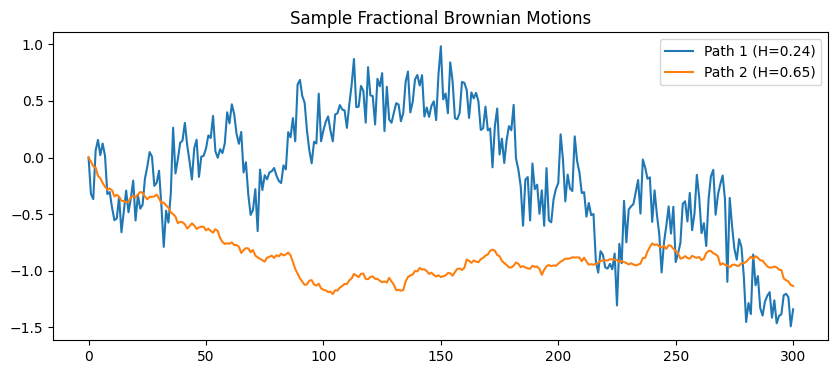

In [64]:
# Visualization
plt.figure(figsize=(10,4))
plt.plot(X_raw[0], label=f"Path 1 (H={y[0]:.2f})")
plt.plot(X_raw[1], label=f"Path 2 (H={y[1]:.2f})")
plt.legend()
plt.title("Sample Fractional Brownian Motions")
plt.show()

### 1. Neural network definition and training (Signature & Deep Signature Models)

#### Signature Definition

Let $x = (x_1, \dots, x_n)$, where $x_i \in \mathbb{R}^d$. Let $f = (f_1, \dots, f_d): [0,1] \to \mathbb{R}^d$ be continuous, such that $f(\frac{i-1}{n-1}) = x_i$, and linear on the intervals in between.

Then the signature of $x$ is defined as the collection of iterated integrals:

$$
\text{Sig}(x) = \left( \left( \dots \int_{0 < t_1 < \dots < t_k < 1} \prod_{j=1}^k \frac{df_{i_j}}{dt}(t_j) dt_1 \dots dt_k \right)_{1 \le i_1, \dots, i_k \le d} \right)_{k \ge 0}
$$

#### Time Augmentation


Signatures have a unique property: they are translation invariant. This means the signature of a stock path starting at 100 is identical to one starting at 200 if they move in the same way. Also, signatures characterize the "shape" of the path, but not necessarily the "speed" at which it is traversed (parameterization invariance).

To fix this and ensure the neural network estimates H correctly, we apply Time Augmentation. We turn our 1D path Xt​ into a 2D path:
$$Path_t​=[t,X_t​]$$

This forces the path to be unique and allows the signature to capture the time dependency.

In [65]:
# Time Augmentation

def prepare_input(X_raw):
    """
    Input shape: (N, Length)
    Output shape: (N, Length, 2) -> The 2 features are [Time, Value]
    """
    n_samples, length = X_raw.shape

    # We create a vector [0, 0.01, 0.02, ... 1.0] for every sample
    t = np.linspace(0, 1, length)
    t_channel = np.tile(t, (n_samples, 1))

    # Stack them together.
    X_augmented = np.stack([t_channel, X_raw], axis=2)

    return X_augmented

# Process the data
X_processed = prepare_input(X_raw)

print(f"Original shape: {X_raw.shape}")    # (1000, 200)
print(f"Augmented shape: {X_processed.shape}") # (1000, 200, 2)

Original shape: (1000, 301)
Augmented shape: (1000, 301, 2)


### Neural Networks Definition:

We will use the 'SigLayer' from keras_sig, this layer take the time series (the fractional Brownian motion trajectory) and calculates its iterated integrals (cf. above definition).

In contrast to Recurrent Neural Networks (RNNs), which process data sequentially, this approach embeds the entire path into a unique, fixed-size feature vector. This representation effectively summarizes the global geometry of the path.

The "Depth" argument, will define the order of the integral used to compute the signature.

In [66]:
#!pip install keras_sig

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from keras_sig import SigLayer

In [68]:
# Signature Model

def build_neural_sig_model(input_shape, truncation_degree=4):
    """
    Builds a neural network with a Signature Layer.

    Args:
        input_shape: (Sequence_Length, Features) -> (200, 2)
        truncation_degree: The depth of the signature transform.
                           Higher degree = more precision but larger output vector.
                           M=4 is usually enough for Hurst estimation.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Signature Layer
    model.add(SigLayer(depth=truncation_degree)) #

    # Hidden Layers
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Output Layer
    model.add(Dense(1, activation='linear'))

    return model

# Build
model = build_neural_sig_model(input_shape=(SEQ_LENGTH, 2), truncation_degree=4) # Input shape is (200, 2)
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sig_layer_23 (SigLayer)         │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

#### We define another neural network but this time with multiple signature layers using steam mode (Deep Signature Model)

In [69]:
# Deep Signature Model

def build_deepsig_model(input_shape, truncation_degree=3):
    """
    Builds a Deep Signature Network (Stacking Signatures).
    """
    model = Sequential()
    model.add(Input(shape=input_shape))

    # First Signature Layer (Stream Mode)
    model.add(SigLayer(depth=truncation_degree, stream=True)) # We use Stream i.e we Calcompute the signature on a rolling window.

    # Intermediate Layer
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))

    # Second Signature Layer
    model.add(SigLayer(depth=truncation_degree)) # Now we summarize the whole sequence into a final vector.

    # Final Layer
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))

    # Output Layer
    model.add(Dense(1, activation='linear'))

    return model

# Build
model_deep = build_deepsig_model((SEQ_LENGTH, 2), truncation_degree=3)
model_deep.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sig_layer_24 (SigLayer)         │ (None, 299, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 299, 32)        │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 299, 32)        │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sig_layer_25 (SigLayer)         │ (None, 33824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │     1,082,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,481 (4.14 MB)

 Trainable params: 1,084,481 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

### Training

We will now try to estimate the hurst exposant, H from the previously generated fractional brownian motion

In [70]:
# Data Generation Train/Test (80%/20%)
split = int(0.8 * N_SAMPLES)
X_train, X_test = X_processed[:split], X_processed[split:]
y_train, y_test = y[:split], y[split:]


In [71]:
# Training & Comparison
EPOCHS = 40
BATCH_SIZE = 32

# Train Neural-Sig
model.compile(optimizer='adam', loss='mse')
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)
print("Training of the Neural-Sig done.")

# Train Deep-Sig
model_deep.compile(optimizer='adam', loss='mse')
hist_deep = model_deep.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE,)
print("Training of the Deep-Sig done.")

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.1233 - val_loss: 0.0409
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0329 - val_loss: 0.0261
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239 - val_loss: 0.0241
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204 - val_loss: 0.0230
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - val_loss: 0.0224
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190 - val_loss: 0.0214
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - val_loss: 0.0209
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - val_loss: 0.0200
Epoch 9/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - val_loss: 0.0185
Epoch 10/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - val_loss: 0.0178
Epoch 11/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0170
Epoch 12/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - val_

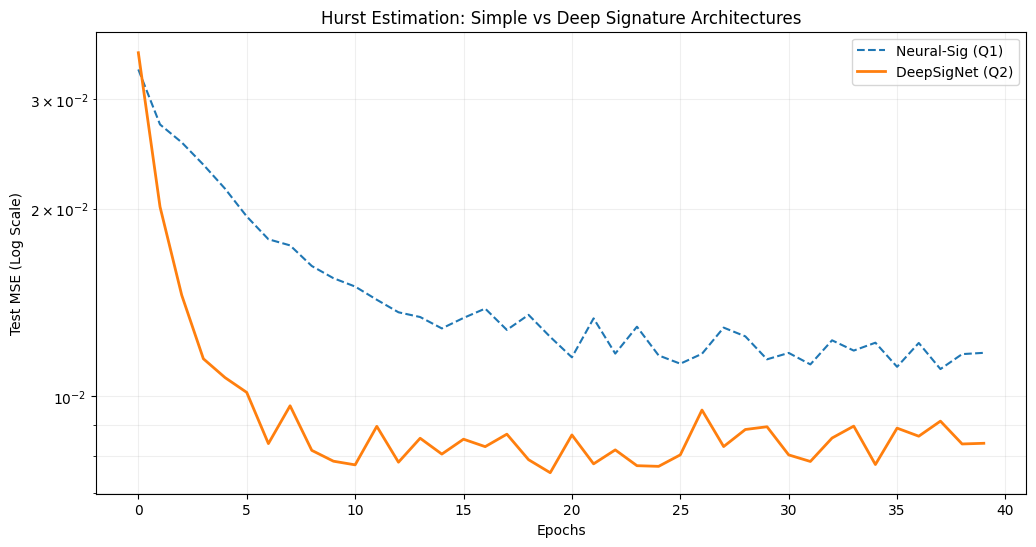

Final Test MSE - Neural-Sig: 0.01174
Final Test MSE - Deep-Sig: 0.00840


In [72]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(hist_q1.history['val_loss'], label='Neural-Sig (Q1)', linestyle='--')
plt.plot(hist_q2.history['val_loss'], label='DeepSigNet (Q2)', linewidth=2)

plt.title('Hurst Estimation: Simple vs Deep Signature Architectures')
plt.ylabel('Test MSE (Log Scale)')
plt.xlabel('Epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Final performance check
print(f"Final Test MSE - Neural-Sig: {hist_q1.history['val_loss'][-1]:.5f}")
print(f"Final Test MSE - Deep-Sig: {hist_q2.history['val_loss'][-1]:.5f}")

First of all, the results of both neural networks converge with great precision despite their simplicity which is very satisfying. Neural Network using signature are performante and adapted to predict the Hurst Exposant.

We observe that the second neural network using a signature layer with streaming is converging much faster with much better accuracy than the first neural network achieving a precision of 8E-3 after convergence.

### 2. Implementation of the DeepSigNeg Architecture

Cf. "Deep Signature Transforms" Paper annexe B.2

"DeepSigNet featured a single Neural-Lift-Signature block, where the neural component was given
by a single convolutional layer with 3 channels and kernel size 3, the lift was the trivial lift of
equation (9), and the signature was truncated as N = 3. The neural component also preserved the
original time-augmented stream of data, so that in some sense the neural component has 3 extra
channels corresponding to time and value. On top of this a feedforward neural network with 5
hidden layers of size 32 was placed. Thus this model is very similar to the Neural-Sig model, except
that a small learnable transformation was allowed before the signature. The difference in their
performance highlights the value of learning a transformation before using the signature. (Without
which the Neural-Sig model is merely outperformed by some non-signature based models.)"

In [73]:
from tensorflow.keras.layers import Conv1D, Concatenate
from tensorflow.keras.models import Model

In [74]:
# DeepSigNet Model

def build_deepsig_paper_model(input_shape):
    """
    Build a DeepSigNet network as described in the paper.
    """
    inputs = Input(shape=input_shape)

    # Neural Component: Conv1D
    neural_feature = Conv1D(filters=3, kernel_size=3, padding='same', activation='relu')(inputs)

    # Lift: Preservation of original stream
    lifted_stream = Concatenate()([inputs, neural_feature])

    # Signature Transform
    signature_features = SigLayer(depth=3, stream=False)(lifted_stream)

    # Feedforward Neural Network
    x = Dense(32, activation='relu')(signature_features)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs, outputs, name="DeepSigNet_Paper")

# Build
model_deepsignet = build_deepsig_paper_model((SEQ_LENGTH, 2))
model_deepsignet.summary()

Model: "DeepSigNet_Paper"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 300, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 300, 3)    │         21 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 300, 5)    │          0 │ input_layer_23[0… │
│ (Concatenate)       │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sig_layer_26        │ (None, 155)       │          0 │ concatenate_5[0]… │
│ (SigLayer)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_109 (Dense)   │ (None, 32)        │      4,992 │ sig_layer_26[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_110 (Dense)   │ (None, 32)        │      1,056 │ dense_109[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 32)        │      1,056 │ dense_110[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 32)        │      1,056 │ dense_111[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 32)        │      1,056 │ dense_112[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_114 (Dense)   │ (None, 1)         │         33 │ dense_113[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,270 (36.21 KB)

 Trainable params: 9,270 (36.21 KB)

 Non-trainable params: 0 (0.00 B)

### 3. Comparaison between Sig, DeepSig, DeepSigNet Models and a standard neural network that will serve as a performance benchmark

In [75]:
from tensorflow.keras.layers import LSTM, Flatten

#### Benchmark Model Definition

In [76]:
# Benchmark Model
def build_benchmark_model(input_shape):
    """
    Build a Benchmark neural network.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(1, activation='linear'))

    return model

# Build
model_benchmark = build_benchmark_lstm((SEQ_LENGTH, 2))
model_benchmark.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,625 (25.88 KB)

 Trainable params: 6,625 (25.88 KB)

 Non-trainable params: 0 (0.00 B)

#### Training

In [77]:
SEQ_LENGTH = X_train.shape[1]

# Model Neural-Sig
model = build_neural_sig_model(input_shape=(SEQ_LENGTH, 2), truncation_degree=3)

# Model DeepSigNet
model_deep = build_deepsig_model(input_shape=(SEQ_LENGTH, 2), truncation_degree=3)

# Model DeepSigNet Paper
model_deepsig_paper = build_deepsig_paper_model(input_shape=(SEQ_LENGTH, 2))

# Model Benchmark
model_benchmark = build_benchmark_model(input_shape=(SEQ_LENGTH, 2))

# Training
models = [model, model_deep, model_deepsig_paper, model_benchmark]
names = ["Sig", "DeepSig", "DeepSig_paper", "Benchmark"]
histories = []

EPOCHS = 40
BATCH_SIZE = 32

for model, name in zip(models, names):
    print(f"\n--- Entraînement de : {name} ---")

    # Compil
    model.compile(optimizer='adam', loss='mse')

    # Training
    h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)
    histories.append(h)
    print(f"Terminé. MSE Final (Test) : {h.history['val_loss'][-1]:.5f}")


--- Entraînement de : Sig ---
Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1900 - val_loss: 0.0372
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0409 - val_loss: 0.0276
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295 - val_loss: 0.0259
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0269 - val_loss: 0.0258
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0242 - val_loss: 0.0256
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245 - val_loss: 0.0250
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0245 - val_loss: 0.0246
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0246 - val_loss: 0.0253
Epoch 9/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - val_loss: 0.0245
Epoch 10/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0233 - val_loss: 0.0237
Epoch 11/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0240
Epoch 12/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0

#### Final Comparaison

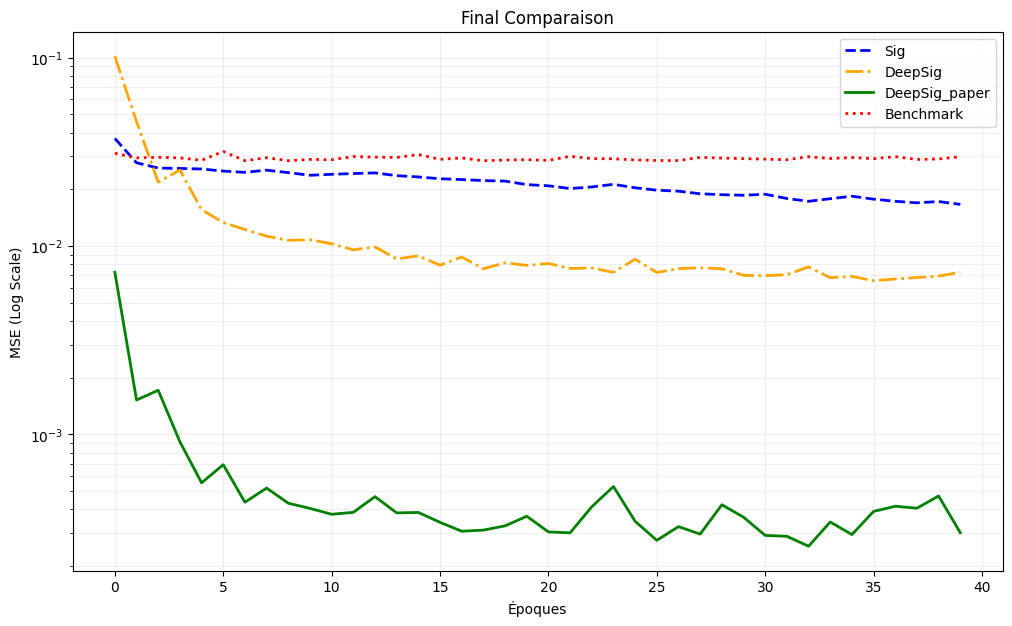

In [78]:
#Plot
plt.figure(figsize=(12, 7))
colors = ['blue', 'orange', 'green', 'red']
styles = ['--', '-.', '-', ':']

for i, h in enumerate(histories):
    plt.plot(h.history['val_loss'],
             label=names[i],
             color=colors[i],
             linestyle=styles[i],
             linewidth=2)

plt.title('Final Comparaison')
plt.xlabel('Époques')
plt.ylabel('MSE (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

First of all, the results of all the neural networks using signatures converge with a greater precision than the benchmark neural network. Moreover, despite their simplicity, all of the NN using signatures display a very satisying precision after convergence.


The two NN using streaming (deep sig models) are significantly more precise than the other model with the version from the annexe B.2 being the better predictor with roughly 2E-4 loss precision after convergence and a faster convergence. These tests where made with N=300, depth=2 and a farely reduced number of parameters, we can expect an even greater precision by scaling the models.


To conclude, Neural Network using signature are very performante in the context of predicting the Hurst Exposant of a time serie.
